<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/DenseNet169_CIFAR100_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet121, CIFAR100

In [1]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [2]:
import os
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(100) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB' #RGB, GRAY, CLASS_LABEL, EDGE

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'DenseNet169_CIFAR100'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 5_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 128
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.05, 'momentum' : 0.9} #{'lr' : 0.02, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.NLLLoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 100),
 'CLASS_NUM': 100,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 32,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 32,
 'PREFIX': 'DenseNet169_CIFAR100',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/DenseNet169_CIFAR100_final.pt',
          'RESULT_IMAGE_PATH': 'result/DenseNet169_CIFAR100_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 5000,
           'LEARNING_PARAMS': {'lr': 0.05, 'momentum': 0.9},
           'LEARNING_PROCESS_RESULT_IMAGE_PATH': 'result/DenseNet169_CIFAR100_result_{}.jpg',
           'LEARNING_PROCESS_RESULT_INTERVAL': 500,
           'LEARNING_

## Define Model

In [0]:
class DenseNet169(torch.nn.Module):
    def __init__(self):
        super(DenseNet169, self).__init__()

        class Block(torch.nn.Module):
            def __init__(self, first_dim, k=32, L=6):
                super(Block, self).__init__()
                self.L = L
                self.blocks = torch.nn.ModuleList()
                self.blocks.append(torch.nn.Sequential(
                        torch.nn.BatchNorm2d(first_dim),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(first_dim, k, kernel_size=1, padding=0, stride=1),
                        torch.nn.BatchNorm2d(k),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(k, k, kernel_size=3, padding=1, stride=1),
                    ))
                
                for i in range(1, L):
                    self.blocks.append(torch.nn.Sequential(
                        torch.nn.BatchNorm2d(k * i + first_dim),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(k * i + first_dim, k, kernel_size=1, padding=0, stride=1),
                        torch.nn.BatchNorm2d(k),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(k, k, kernel_size=3, padding=1, stride=1),
                    ))
                
            def forward(self, x):
                xs = [None for _ in range(self.L + 1)]
                xs[0] = x
                xs[1] = self.blocks[0](x)
                
                for i in range(1, self.L):
                    x_in = xs[i]
                    for j in range(i):
                        x_in = torch.cat([x_in, xs[j]], dim=1)
                    x = self.blocks[i](x_in)
                    xs[i + 1] = x
                        
                x = xs[0]
                for i in range(1, (self.L + 1)):
                    x = torch.cat([x, xs[i]], dim=1)

                return x

        k = 32
        theta = 0.5
        self.bn1 = torch.nn.BatchNorm2d(cfg.INPUT_CHANNEL)
        self.conv1 = torch.nn.Conv2d(cfg.INPUT_CHANNEL, k * 2, kernel_size=7, padding=3, stride=2)
        
        # Dense block1
        block1_L = 6
        block1_dim = int(k * block1_L * theta)
        
        self.block1 = Block(first_dim = k * 2, L = block1_L)
        
        # Transition layer1
        self.transition1 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(k * block1_L + k * 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(k * block1_L + k * 2, block1_dim, kernel_size=1, padding=0, stride=1),
            torch.nn.AvgPool2d(2, stride=2, padding=0)
        )
    
        # Dense block2
        block2_L = 12
        block2_dim = int(k * block2_L * theta)
        
        self.block2 = Block(first_dim = block1_dim, L = block2_L)

        # Transition layer2        
        self.transition2 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(k * block2_L + block1_dim),
            torch.nn.ReLU(),
            torch.nn.Conv2d(k * block2_L + block1_dim, block2_dim, kernel_size=1, padding=0, stride=1),
            torch.nn.AvgPool2d(2, stride=2, padding=0)
        )
        
        # Dense block3
        block3_L = 32
        block3_dim = int(k * block3_L * theta)
        
        self.block3 = Block(first_dim = block2_dim, L = block3_L)
        
        # Transition layer3
        self.transition3 = torch.nn.Sequential(
            torch.nn.BatchNorm2d(k * block3_L + block2_dim),
            torch.nn.ReLU(),
            torch.nn.Conv2d(k * block3_L + block2_dim, block3_dim, kernel_size=1, padding=0, stride=1),
            torch.nn.AvgPool2d(2, stride=2, padding=0)
        )
        
        # Dense block4
        block4_L = 32
        self.block4 = Block(first_dim = block3_dim, L = block4_L)
        
        self.linear = torch.nn.Linear(k * block4_L + block3_dim, cfg.CLASS_NUM)
        
        
    def forward(self, x):
        # Entry flow
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv1(x)
        
        x = F.max_pool2d(x, 3, padding=1, stride=2)
        
        x = self.block1(x)
        
        x = self.transition1(x)
        
        x = self.block2(x)
        
        x = self.transition2(x)
        
        x = self.block3(x)
        
        x = self.transition3(x)
        
        x = self.block4(x)

        x = F.avg_pool2d(x, [cfg.INPUT_HEIGHT // 32, cfg.INPUT_WIDTH // 32], padding=0, stride=1)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        
        return x

## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size > self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            else:
                inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
                mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds


#---
# preprocess for torchvision.datasets
#---
def preprocess(Xs, cfg, mode, hf=False, vf=False, rot=False):
    xs = []

    for x in Xs:
        # resize
        x = cv2.resize(x, (cfg.INPUT_WIDTH, cfg.INPUT_HEIGHT)).astype(np.float32)
        
        # channel BGR -> Gray
        if mode == 'GRAY':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = np.expand_dims(x, axis=-1)
        elif mode == 'EDGE':
            x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
            x = cv2.Canny(x, 100, 150)
            x = np.expand_dims(x, axis=-1)

        # horizontal flip
        if hf and np.random.rand() < 0.5:
            x = x[:, ::-1]

        # vertical flip
        if vf and np.random.rand() < 0.5:
            x = x[::-1]

        # rotation
        if rot != False:
            rot = np.random.randint(0, 360, 1) // rot * rot

            scale = 1

            _h, _w = x.shape[:2]
            _c = 1
            if len(x.shape) == 3:
                _c = x.shape[2]

            max_side = max(_h, _w)
            tmp = np.zeros((max_side, max_side, _c))
            tx = int((max_side - _w) / 2)
            ty = int((max_side - _h) / 2)
            tmp[ty: ty+_h, tx: tx+_w] = x.copy()
            M = cv2.getRotationMatrix2D((max_side / 2, max_side / 2), rot, scale)
            _x = cv2.warpAffine(tmp, M, (max_side, max_side))
            x = _x[tx:tx+_w, ty:ty+_h]

        if mode == 'CLASS_LABEL':
            _x = x
            x = np.zeros((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.CLASS_NUM), dtype=np.int)

            for i, (_, vs) in enumerate(cfg.CLASS_LABEL.items()):
                ind = (_x[..., 0] == vs[0]) * (_x[..., 1] == vs[1]) * (_x[..., 2] == vs[2])
                x[..., i][ind] = 1

        else:
            # normalization [0, 255] -> [-1, 1]
            x = x / 127.5 - 1

        xs.append(x)
                
    xs = np.array(xs, dtype=np.float32)
    if cfg.CHANNEL_AXIS == 1:
        if len(xs.shape) == 4:
            xs = xs.transpose(0, 3, 1, 2)
        else:
            xs = np.expand_dims(xs, axis=1)
    else:
        if len(xs.shape) == 3:
            xs = np.expand_dims(xs, axis=-1)

    return xs

## Train

In [5]:
def train():
    # model
    model = DenseNet169().to(cfg.DEVICE)
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = np.array(trainset.data)
    ts_data = np.array(trainset.targets, dtype=int)
    data_num = len(Xs_data)
    #train_ts = np.identity(cfg.CLASS_NUM)[trainset.targets] # one hot

    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    list_iter = []
    list_loss= []
    list_accuracy = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ts = torch.tensor(ts_data[mb_inds], dtype=torch.long).to(cfg.DEVICE)

        # forward and update
        opt.zero_grad()

        ys = model(Xs)

        loss = cfg.TRAIN.LOSS_FUNCTION(torch.log(ys), ts)
        loss.backward()
        opt.step()
    
        preds = ys.argmax(dim=1, keepdim=True).reshape(-1)
        accuracy = (preds == ts).sum() / float(cfg.TRAIN.MINIBATCH)

        _loss = loss.item()
        _accuracy = accuracy.item()

        progres_bar += '|'

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')

                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))


    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 16, 16]           9,472
       BatchNorm2d-3             [-1, 64, 8, 8]             128
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           2,080
       BatchNorm2d-6             [-1, 32, 8, 8]              64
              ReLU-7             [-1, 32, 8, 8]               0
            Conv2d-8             [-1, 32, 8, 8]           9,248
       BatchNorm2d-9             [-1, 96, 8, 8]             192
             ReLU-10             [-1, 96, 8, 8]               0
           Conv2d-11             [-1, 32, 8, 8]           3,104
      BatchNorm2d-12             [-1, 32, 8, 8]              64
             ReLU-13             [-1, 32, 8, 8]               0
           Conv2d-14             [-1, 3

Extracting ./data/cifar-100-python.tar.gz to ./data/
training start

Iter:50, Loss:4.1330, Accu:0.0469
Iter:100, Loss:4.0729, Accu:0.0625
Iter:150, Loss:3.8834, Accu:0.1016
Iter:200, Loss:3.5697, Accu:0.1328
save >> models/DenseNet169_CIFAR100_iter200.pt
Iter:250, Loss:3.3146, Accu:0.2188
Iter:300, Loss:3.4294, Accu:0.1953
Iter:350, Loss:3.1070, Accu:0.2266
Iter:400, Loss:3.2264, Accu:0.1250
save >> models/DenseNet169_CIFAR100_iter400.pt
Iter:450, Loss:3.5876, Accu:0.1094
Iter:500, Loss:3.5905, Accu:0.1250
Iter:550, Loss:3.1517, Accu:0.1328
Iter:600, Loss:3.4708, Accu:0.1094
save >> models/DenseNet169_CIFAR100_iter600.pt
Iter:650, Loss:3.1610, Accu:0.1484
Iter:700, Loss:3.1851, Accu:0.1562
Iter:750, Loss:3.1234, Accu:0.1641
Iter:800, Loss:3.0100, Accu:0.1562
save >> models/DenseNet169_CIFAR100_iter800.pt
Iter:850, Loss:3.0394, Accu:0.1641
Iter:900, Loss:2.6865, Accu:0.2109
Iter:950, Loss:2.9528, Accu:0.1484
Iter:1000, Loss:2.8626, Accu:0.1562
save >> models/DenseNet169_CIFAR100_iter100

## plot Loss, Accuracy

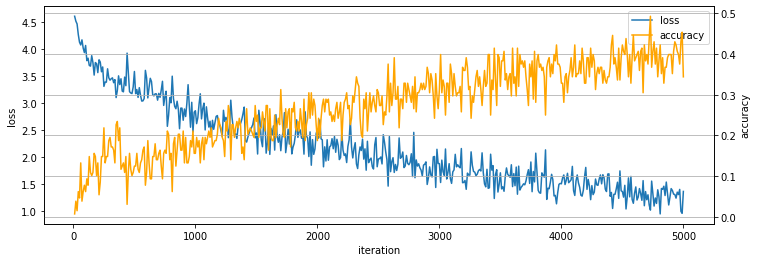

In [6]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
Files already downloaded and verified
10000 / 10000
accuracy = 0.36025528169014087
ts / pred table
array([[4200.,    0.,    0., ...,    0.,    0.,    0.],
       [   0., 3200.,    0., ...,    0.,  100.,    0.],
       [   0.,    0., 1100., ...,  100., 1100.,    0.],
       ...,
       [   0.,    0.,    0., ..., 3500.,    0.,  100.],
       [   0.,    0.,  100., ...,    0., 2900.,    0.],
       [   0.,    0.,    0., ...,    0.,    0., 4200.]])


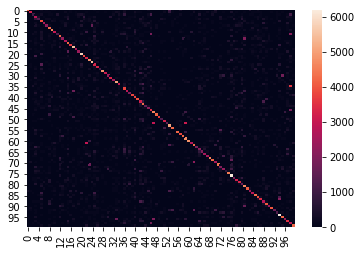

In [7]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = DenseNet169().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    np.random.seed(0)

    trainset = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = np.array(trainset.data)
    ts_data = np.array(trainset.targets, dtype=int)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])

    inds = np.arange(data_num)

    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i : min(i + cfg.TEST.MINIBATCH, data_num)]
            Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
            ts = ts_data[mb_inds]

            # forward
            ys = model(Xs).detach().cpu().numpy()
            ys = ys.argmax(axis=1)
            
            for t, y in zip(ts, ys):
                table[ts, ys] += 1

            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')

    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\naccuracy =', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)

test()

In [8]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")


usage: ipykernel_launcher.py [-h] [--train] [--test]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-4e3fd29c-5b48-44a1-b4cc-712bccf0feec.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
